# How I used Claude to match 200 Clinical Trials to 700 PubMed Papers

Claude Code is a powerful general-purpose coding agent that can design and execute multi-stage data pipelines. However, it's commonly tripped up by messy real-world data operations problems: *I have two tables to merge, with no common key, and matching requires a deep understanding of the subject matter.*

But when powered by a tool purpose-built for large scale data operations like merging, Claude Code produces shockingly better results.

This notebook compares what Claude Code does on its own versus what it achieves when it can call the everyrow plugin.

<small><i>You can also scroll straight to the end to see instructions for installing the everyrow plugin</i></small>

---

## Approach 1: Claude Code Only

When given a table of clinical trials and a table of PubMed papers, then tasked with finding which paper(s) report results for which trial, Claude Code independently devised and executed a multi-stage strategy:

**Phase 1: TF-IDF pre-filtering.**
Built TF-IDF text representations for all trials and papers, computed cosine similarity, and selected the top-15 candidate papers per trial. This narrowed the 200 × 700 = 140,000 possible pairs down to ~3,000 candidates.

**Phase 2: Direct NCT ID matching.**
Searched paper abstracts for explicit NCT ID mentions using regex. Found 8 papers that directly cite their trial’s identifier.

**Phase 3: 8 parallel LLM subagents.**
Split the 200 trials into 8 batches of 25. Each subagent received its batch of trials plus TF-IDF candidate papers, and assessed whether candidates were genuine matches — checking alignment of interventions, conditions, study design, sponsors, endpoints, and institutions.

**Claude Code Only — Results (200 trials + 700 papers):**

| Metric | Value |
|---|---|
| F1 Score | 74.5% |
| Precision | 100% |
| Recall | ~59% |
| Runtime | ~6 min |
| Estimated cost | ~$10–15 |

Claude Code achieved **perfect precision** — every match it reported was correct. But it missed over 40% of the true matches. The conservative TF-IDF pre-filtering and high-confidence thresholds meant many genuine but harder-to-detect links were never surfaced.

> **The fixed-budget problem**: Claude Code allocated exactly 8 subagents regardless of whether the paper pool contained 200 or 700 papers. Each agent handled 25 trials — the same workload whether it was searching through 200 or 700 candidates. As the dataset grows, each agent's search space expands but its compute budget doesn't.

## Approach 2: Claude Code + everyrow

When given the same task with everyrow, the entire merge is a single function call. Behind the scenes, `merge()` orchestrates hundreds of LLM agents that build an understanding of each trial’s key attributes, search through the paper pool for semantic matches, and verify candidates with detailed reasoning.

Since multiple papers can report results from the same trial (e.g., primary results and follow-up analyses), this is a **many-to-one** mapping: papers (left) map to trials (right). Getting the table orientation right matters — the left table is the "many" side.

## Comparing Results

| | **Claude Code + everyrow** | **Claude Code alone** |
|---|---|---|
| **What you write** | A single `merge()` call | A prompt describing the task |
| **What happens** | everyrow orchestrates hundreds of LLM agents | Claude builds a custom TF-IDF + subagent pipeline |
| **F1 Score** | **87.2%** | 74.5% |
| **Precision / Recall** | 84.1% / 90.6% | 100% / ~59% |
| **Runtime** | 13.5 min | ~6 min |
| **Cost** | ~$20 | ~$10–15 |

## How Performance Scales

We ran the same experiment at a smaller scale (200 trials + 200 papers) to see how both approaches respond to growing data.

**At 200 + 200 papers**, Claude Code independently chose a similar strategy: regex NCT ID extraction (3 matches), followed by 8 parallel subagents using keyword-based search (`Grep`) on a papers text file. Each agent handled 25 trials across 200 papers.

| | **200 trials + 200 papers** | **200 trials + 700 papers** |
|---|---|---|
| **CC + everyrow — F1** | 85.7% | 87.2% |
| **CC Only — F1** | 78.8% | 74.5% |
| **CC + everyrow — cost** | ~$6 | ~$18 |
| **CC Only — cost** | ~$15 | ~$12 |
| **CC + everyrow — time** | 2.7 min | 13.5 min |
| **CC Only — time** | 7 min | 6 min |

The key finding: everyrow dynamically scales its resources to match the problem, maintaining accuracy as datasets grow. Claude Code alone allocates a fixed budget of subagents regardless of dataset size, so its accuracy degrades as the problem gets bigger.

A pattern emerges:

- **everyrow's F1 held steady** (85.7% → 87.2%) as the paper pool grew 3.5×. It allocated proportionally more resources to handle the larger search space.
- **Claude Code's F1 degraded** (78.8% → 74.5%). It used the same 8 subagents and TF-IDF top-15 filtering regardless of dataset size, so each agent's search became less thorough.
- **Claude Code's cost stayed flat** (~$12–15 in both cases). This is the signature of a ≈fixed-budget approach: the same compute is spent whether the problem is small or large.
- **everyrow's cost scaled with the problem** ($6 → $18). The extra spend went directly toward maintaining quality at scale.

At 200 + 200, everyrow was cheaper, faster, and more accurate. At 200 + 700, the accuracy gap widened. Extrapolating to larger datasets (thousands of trials and papers), we would expect the gap to grow further: Claude Code's fixed 8-agent budget would be spread even thinner, while EveryRow would continue to scale its orchestration, thus nicely *complementing* Claude Code.

## Key Takeaways

**1. Specialized orchestration beats general-purpose agent planning for data operations at scale.**
everyrow's `merge()` is purpose-built to decompose a large matching problem into hundreds of parallel agent tasks, with intelligent candidate selection and verification. Claude Code is remarkably clever — it independently invented a TF-IDF + parallel-subagent pipeline — but a general-purpose coding agent can't match a system designed specifically for this class of problem.

**2. The recall gap is the key differentiator.**
Claude Code achieved perfect precision (100%) — every match it reported was correct. But it only found ~59% of the true links. everyrow's higher F1 comes from substantially better recall: it surfaces matches that a fixed-budget approach misses.

**3. Fixed resources → degrading quality.**
Claude Code used 8 subagents for both the 200-paper and 700-paper runs. This is a natural consequence of how coding agents plan: they estimate a reasonable level of parallelism and stick with it. As the dataset grows, each agent's workload increases but the total compute stays constant. EveryRow, by contrast, scales its agent count to the problem.

**4. Cost is about what you get for your money.**
At the 200 + 700 scale, everyrow cost ~$18 and achieved 87.2% F1. Claude Code cost ~$12 and achieved 74.5% F1. The relevant metric isn't raw cost but cost per unit of quality. The ~$6 in savings from Claude Code comes at the price of missing 40%+ of the true matches.

## Reproduce It Yourself

This dataset (200 trials + 700 papers) was sized to fit within everyrow's free-tier credits (~$20). To reproduce:

1. Run the cells below to execute the everyrow merge and score it
2. To test Claude Code alone, give it the `trials_200.csv` and `papers_700.csv` files and ask it to match papers to trials
3. Save Claude Code's predictions as a CSV with `nct_id` and `pmid` columns, then score with:

## The Task

[ClinicalTrials.gov](https://clinicaltrials.gov/) maintains structured metadata for clinical trials: conditions studied, interventions tested, outcomes measured, sponsors, and timelines. When a trial's results are published, the publication is linked to the trial record.

PubMed papers describe the same studies in natural language: titles and abstracts discuss the intervention, patient population, endpoints, and findings.

**The matching problem**: given a trial's structured metadata and a paper's title + abstract, determine whether the paper reports results from that trial. This requires:

- Recognizing that a brand name in a trial record (e.g., "PGL4001") maps to a generic name in a paper (e.g., "ulipristal acetate")
- Matching disease terminology across ontologies (e.g., "uterine myomas" vs. "uterine fibroids")
- Distinguishing studies with similar interventions but different populations or designs
- Linking sponsor organizations, outcome measures, and study timelines across formats

## Dataset

The evaluation dataset was constructed as follows:

1. **Trials with known links**: We queried the [ClinicalTrials.gov API](https://clinicaltrials.gov/data-api/about-api) for completed trials that have `RESULT` or `DERIVED` reference types pointing to PubMed IDs. These known links serve as gold labels.

2. **PubMed papers**: We scanned the [PubMed 2019 baseline JSONL](https://www.kaggle.com/datasets/tunguz/pubmed-title-abstracts-2019-baseline) (~20 GB, ~19M papers) to extract:
   - **Gold papers**: those whose PMIDs match the trial references
   - **Distractor papers**: reservoir-sampled English-language papers with abstracts ≥100 characters, at a 10:1 distractor-to-gold ratio

3. **Subsampling**: To keep this example reproducible within everyrow's free-tier credits, we subsampled to **200 trials** and **700 papers** (64 gold papers + 636 distractors).

**A note on gold labels**: `gold_labels_200.csv` contains 64 `(nct_id, pmid)` pairs. All 64 gold PMIDs are present in `papers_700.csv`, so all pairs are achievable. If you use a smaller paper subset, you must filter the gold labels to only pairs whose PMID is in your paper set — otherwise you'll penalize recall for matches that are impossible to find. The `score_from_csv` helper below handles this automatically.

In [ ]:
# Setup: install everyrow if needed and configure API key
%pip install everyrow matplotlib

import os
if "EVERYROW_API_KEY" not in os.environ:
    os.environ["EVERYROW_API_KEY"] = "your-api-key-here"  # Get one at everyrow.io

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from everyrow import create_session
from everyrow.ops import merge

pd.set_option("display.max_colwidth", 100)

In [ ]:
trials_df = pd.read_csv("trials_200.csv")
papers_df = pd.read_csv("papers_700.csv")

print(f"Trials: {len(trials_df)} rows, {len(trials_df.columns)} columns")
print(f"Papers: {len(papers_df)} rows, {len(papers_df.columns)} columns")
print(f"\nTrial columns: {list(trials_df.columns)}")
print(f"Paper columns: {list(papers_df.columns)}")

Trials: 200 rows, 12 columns
Papers: 700 rows, 3 columns

Trial columns: ['nct_id', 'brief_title', 'official_title', 'conditions', 'study_type', 'phases', 'interventions', 'intervention_descriptions', 'primary_outcomes', 'sponsor', 'completion_date', 'start_date']
Paper columns: ['pmid', 'title', 'abstract']


In [2]:
trials_df[["nct_id", "brief_title", "conditions", "interventions", "sponsor"]].head(5)

,nct_id,brief_title,conditions,interventions,sponsor
0,NCT03329456,MEV to Block the Posterior and Lateral Cords of the Infraclavicular Brachial Plexus,Shoulder Disease; Anesthesia,Ropivacaine,University Hospital of North Norway
1,NCT00648115,Evaluating Vocational Materials for Incarcerated Veterans With Mental Illness or Substance Abuse,Mental Illness,Basic Vocational Services; Self-Study; Group Program,VA Office of Research and Development
2,NCT00740831,PGL4001 Versus GnRH-agonist in Uterine Myomas,Uterine Myomas,PGL4001; leuprorelin,PregLem SA
3,NCT00922350,Heliox and Posture in Patients With Asthma,Acute Asthma,HELIOX; OXYGEN; HELIOX+POSTURE; OXYGEN + POSTURE,Universidade Federal de Pernambuco
4,NCT03737552,Sleep Patterns in Children and Adolescents With ADHD,Sleep Disorder; ADHD; Cognitive Change,Polysomnography,Assiut University


In [3]:
papers_df.head(3)

,pmid,title,abstract
0,21435708,Viral pneumonia.,About 200 million cases of viral community-acquired pneumonia occur every year-100 million in ch...
1,26627400,CO2 Activation by Nb(+) and NbO(+) in the Gas Phase. A Case of Two-State Reactivity Process.,Gas-phase carbon dioxide activation by Nb(+) and NbO(+) was studied at the density functional le...
2,25391500,A novel alkyl hydroperoxidase (AhpD) of Anabaena PCC7120 confers abiotic stress tolerance in Esc...,"In silico analysis together with cloning, molecular characterization and heterologous expression..."


## Merge Using everyrow

In [ ]:
async with create_session(name="Clinical Trials to Papers Matching") as session:
    print(f"Session URL: {session.get_url()}")
    result = await merge(
        session=session,
        task=(
            "Match publications to the clinical trial they report results for. A paper matches a trial if the paper describes the results of that trial - look for matching interventions/drugs, conditions/diseases, study design, outcomes, and sponsor/institution. Trial titles may be rewritten in the paper. Drug names may appear as brand or generic. Not every paper has a matching trial and not every trial has a matching paper."
        ),
        left_table=papers_df,
        right_table=trials_df,
    )

## Scoring a Merge

We evaluate merge quality using standard information retrieval metrics on the set of predicted `(nct_id, pmid)` pairs:

- **Precision** = correct pairs / predicted pairs — *"Of the matches we found, how many are real?"*
- **Recall** = correct pairs / gold pairs — *"Of the real matches, how many did we find?"*
- **F1** = harmonic mean of precision and recall

A system with perfect precision but low recall is too conservative: it only reports matches it's certain about, but misses many real links. In practice, **missed links are harder to recover than false positives** (which can be reviewed), so recall matters.

In [4]:
def score_merge(predicted_pairs, gold_pairs):
    """Score predicted (nct_id, pmid) pairs against gold labels."""
    predicted_pairs = set(predicted_pairs)
    gold_pairs = set(gold_pairs)

    tp = predicted_pairs & gold_pairs
    fp = predicted_pairs - gold_pairs
    fn = gold_pairs - predicted_pairs

    precision = len(tp) / len(predicted_pairs) if predicted_pairs else 0
    recall = len(tp) / len(gold_pairs) if gold_pairs else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    print(f"Predicted pairs: {len(predicted_pairs)}")
    print(f"Gold pairs:      {len(gold_pairs)}")
    print(f"True positives:  {len(tp)}")
    print(f"False positives: {len(fp)}")
    print(f"False negatives: {len(fn)}")
    print(f"\u2500" * 30)
    print(f"Precision: {precision:.1%}")
    print(f"Recall:    {recall:.1%}")
    print(f"F1 Score:  {f1:.1%}")

    return {"precision": precision, "recall": recall, "f1": f1}


def score_from_csv(result_csv, gold_csv="gold_labels_200.csv", paper_csv=None):
    """Score a merge result CSV against gold labels.

    The result CSV should have 'nct_id' and 'pmid' columns.
    Rows where nct_id is null are treated as unmatched.

    If paper_csv is provided, gold pairs are filtered to only those
    whose PMID exists in the paper set (achievable gold pairs). This
    matters when using a paper subset that doesn't contain all gold PMIDs.
    """
    result_df = pd.read_csv(result_csv)
    gold_df = pd.read_csv(gold_csv)

    matched = result_df.dropna(subset=["nct_id"])
    predicted = set(zip(matched["nct_id"], matched["pmid"].astype(str)))
    gold = set(zip(gold_df["nct_id"], gold_df["pmid"].astype(str)))

    # Filter to achievable gold pairs
    if paper_csv is not None:
        paper_pmids = set(pd.read_csv(paper_csv)["pmid"].astype(str))
        achievable = {(nct, pmid) for nct, pmid in gold if pmid in paper_pmids}
        print(f"Achievable gold pairs (PMID in paper set): {len(achievable)} / {len(gold)}")
        gold = achievable

    return score_merge(predicted, gold)


# Load gold labels
gold_df = pd.read_csv("gold_labels_200.csv")
gold_pairs = set(zip(gold_df["nct_id"], gold_df["pmid"].astype(str)))
print(f"Gold label pairs: {len(gold_pairs)} (across {gold_df['nct_id'].nunique()} trials)")

Gold label pairs: 64 (across 64 trials)


In [6]:
# Extract predicted pairs from the merge result
merged = result.data.dropna(subset=["nct_id"])
er_predicted = set(zip(merged["nct_id"], merged["pmid"].astype(str)))

print("=== Claude Code + everyrow ===")
er_scores = score_merge(er_predicted, gold_pairs)

=== Claude Code + everyrow ===
Predicted pairs: 69
Gold pairs:      64
True positives:  58
False positives: 11
False negatives: 6
──────────────────────────────
Precision: 84.1%
Recall:    90.6%
F1 Score:  87.2%


## Head-to-Head: 200 Trials × 700 Papers

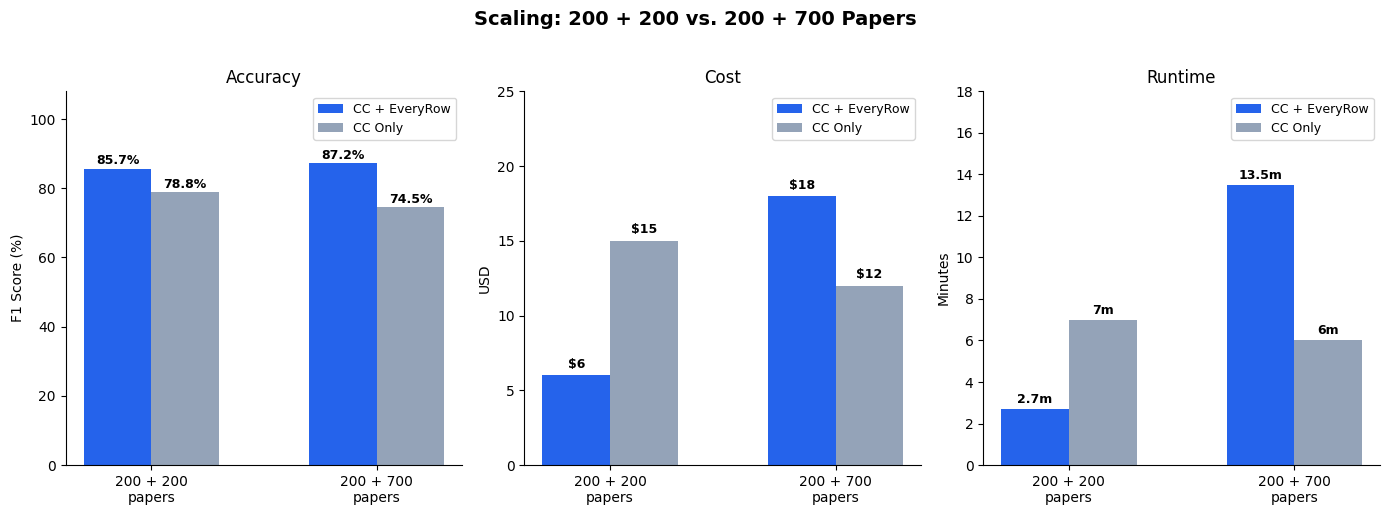

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

scales = ["200 + 200\npapers", "200 + 700\npapers"]
x = np.arange(len(scales))
w = 0.3

er_color = "#2563eb"
cc_color = "#94a3b8"

# --- F1 Score ---
er_f1 = [85.7, 87.2]
cc_f1 = [78.8, 74.5]
axes[0].bar(x - w / 2, er_f1, w, label="CC + everyrow", color=er_color)
axes[0].bar(x + w / 2, cc_f1, w, label="CC Only", color=cc_color)
for i in range(len(scales)):
    axes[0].text(i - w / 2, er_f1[i] + 1.2, f"{er_f1[i]}%", ha="center", fontsize=9, fontweight="bold")
    axes[0].text(i + w / 2, cc_f1[i] + 1.2, f"{cc_f1[i]}%", ha="center", fontsize=9, fontweight="bold")
axes[0].set_ylabel("F1 Score (%)")
axes[0].set_title("Accuracy")
axes[0].set_xticks(x)
axes[0].set_xticklabels(scales)
axes[0].set_ylim(0, 108)
axes[0].legend(fontsize=9)

# --- Cost ---
er_cost = [6, 18]
cc_cost = [15, 12]
axes[1].bar(x - w / 2, er_cost, w, label="CC + everyrow", color=er_color)
axes[1].bar(x + w / 2, cc_cost, w, label="CC Only", color=cc_color)
for i in range(len(scales)):
    axes[1].text(i - w / 2, er_cost[i] + 0.5, f"${er_cost[i]}", ha="center", fontsize=9, fontweight="bold")
    axes[1].text(i + w / 2, cc_cost[i] + 0.5, f"${cc_cost[i]}", ha="center", fontsize=9, fontweight="bold")
axes[1].set_ylabel("USD")
axes[1].set_title("Cost")
axes[1].set_xticks(x)
axes[1].set_xticklabels(scales)
axes[1].set_ylim(0, 25)
axes[1].legend(fontsize=9)

# --- Runtime ---
er_time = [2.7, 13.5]
cc_time = [7, 6]
axes[2].bar(x - w / 2, er_time, w, label="CC + everyrow", color=er_color)
axes[2].bar(x + w / 2, cc_time, w, label="CC Only", color=cc_color)
for i in range(len(scales)):
    axes[2].text(i - w / 2, er_time[i] + 0.3, f"{er_time[i]}m", ha="center", fontsize=9, fontweight="bold")
    axes[2].text(i + w / 2, cc_time[i] + 0.3, f"{cc_time[i]}m", ha="center", fontsize=9, fontweight="bold")
axes[2].set_ylabel("Minutes")
axes[2].set_title("Runtime")
axes[2].set_xticks(x)
axes[2].set_xticklabels(scales)
axes[2].set_ylim(0, 18)
axes[2].legend(fontsize=9)

for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.suptitle("Scaling: 200 + 200 vs. 200 + 700 Papers", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()